Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [x] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Begin with baselines for classification.
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ 
] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [175]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def setup_data():
    train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'),  #thanks
                     pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
    test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
    sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
    return train, test, sample_submission


train,test, _ = setup_data()  #kaggle 

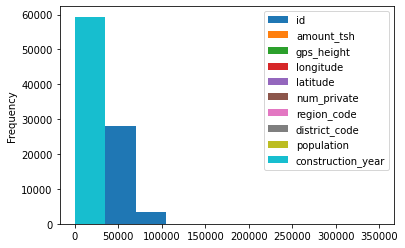

In [177]:

train.shape, test.shape
target = 'status_group'
train.plot(x=target, kind='hist')


In [178]:
#we do another split on our training dataframe
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=8)


In [179]:

def wrangle(X):
    #do some stuff
      # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    if ('latitude' in X.index):
        X['latitude'] = X['latitude'].replace(-2e-08, 0)
        # When columns have zeros and shouldn't, they are like null values.
        # So we will replace the zeros with nulls, and impute missing values later.
        cols_with_zeros = ['longitude', 'latitude']
        for col in cols_with_zeros:
            X[col] = X[col].replace(0, np.nan)
    if ('permit' in X.index):
        X['permit'] = X['permit'].astype('str')
        X['permit'] = X['permit'].replace({'True': 'yes','False': 'no'})
    # quantity & quantity_group are duplicates, so drop one
    dropcols = ['wpt_name',
                'ward','scheme_name',
                'id']
    for i in dropcols:
        if i in X.index:
            X.drop(labels=i, axis=1, inplace=True)
    #X['age'] = pd.DatetimeIndex(X['date_recorded']).year - X.construction_year #not good due to zeros

    return X


/home/dliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['gps_height', 'region_code', 'district_code', 'amount_tsh', 'construction_year', 'longitude']


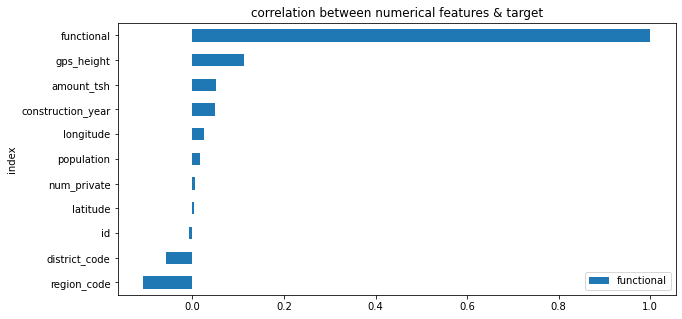

In [180]:
## feature selection  look at numericals cols
train['functional'] = (train['status_group']=='functional').astype(int)

train.corr().reset_index().sort_values('functional').plot(x='index',
                                                          y='functional',
                                                          figsize=(10,5),
                                                          kind ='barh',
                                                         title='correlation between numerical features & target')

cor = train.copy().corr().reset_index().sort_values(by='functional')
cor.functional = cor.functional.apply(abs)

ncols =cor.sort_values('functional',ascending=False)['index'][1:7].values.tolist()  #ordered by absolute correlation
print(ncols)




In [315]:
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()
print(categorical_features)


def arrange(df,features, target): #for validation / selection only 

    train, val = train_test_split(df, train_size=0.80, test_size=0.20, 
                                  stratify=df[target], random_state=8) 
    train = wrangle(train) #dataframes 
    val   = wrangle(val)   #new dataframmes 
    X_train = train[features]
    y_train = train[target]
    X_val = val[features]
    y_val = val[target]

    return X_train, y_train, X_val, y_val    


['basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [182]:


def reduce_features(x):
    return (x[ft19])     #return the subset of encoded features we selected 

#pipeline 

from sklearn.preprocessing import FunctionTransformer
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler  scaling not usd for treees


#reduce complexity of DT to bias model away from training data to validation. .. ie. reduce variance. 
#change / increase 'min node size  aka min samples per leaf'

pipeline_red = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(min_samples_leaf=20, random_state=88)
)

pipeline19 =make_pipeline(      #same 
    ce.OneHotEncoder(use_cat_names=True),
    FunctionTransformer(reduce_features),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(random_state=88)
)
pipeline_red19 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    FunctionTransformer(reduce_features),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(min_samples_leaf=30, random_state=88)
)


arrange ['basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
target status_group


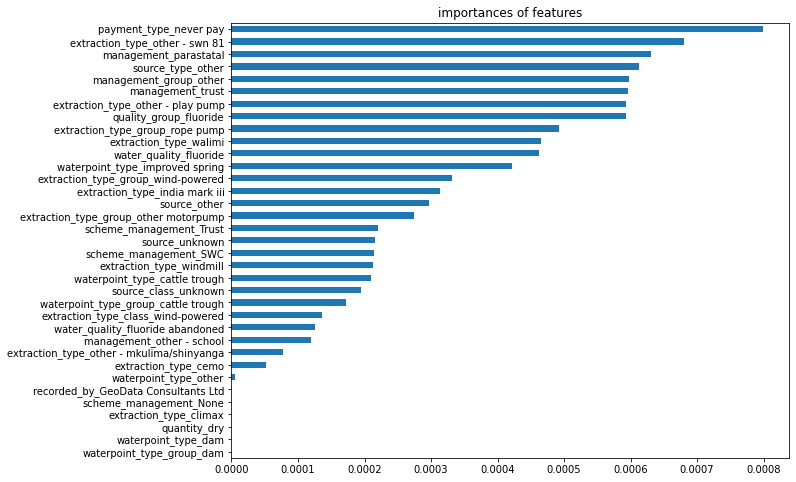

Index(['quantity_group_dry', 'waterpoint_type_group_other',
       'waterpoint_type_communal standpipe multiple', 'permit_True',
       'payment_never pay', 'management_vwc', 'region_Kigoma', 'permit_False',
       'quantity_enough', 'scheme_management_VWC', 'payment_type_per bucket',
       'region_Iringa', 'source_type_spring', 'extraction_type_class_gravity',
       'region_Shinyanga', 'basin_Lake Nyasa', 'public_meeting_False',
       'public_meeting_True', 'basin_Internal'],
      dtype='object')
Train Accuracy 0.8377104377104377
validation accuracy 0.765993265993266


In [263]:
#plot importances of plain model  usint only categorical
X_train, y_train, X_val, y_val = arrange(train, categorical_features, target)

pipeline =make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(random_state=88)
)
pipeline.fit(X_train, y_train)

model = pipeline.named_steps['decisiontreeclassifier']
encoder= pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns     #get the column names back
model.feature_importances_                          #feature importances vs coeffs
importances = pd.Series(model.feature_importances_, encoded_columns)
importances.sort_values().head(35).plot.barh(figsize=(10,8),title='importances of features')
plt.show()

top20cats =importances.sort_values(ascending=False).index[:19]
print(top20cats)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('validation accuracy', pipeline.score(X_val, y_val))

#predict on test
#y_pred = pipeline.predict(X_test)

cats2 = ['quantity', 'waterpoint_type',
         'payment_type','permit', 'management',
         'region','basin', 'scheme_management',
         'quantity_group','public_meeting','extraction_type_group']
cats3 = ['quantity', 'waterpoint_type','source_type','source',
         'payment_type','permit', 'management', 'extraction_type',
         'region','basin', 'scheme_management',
         'quantity_group']

In [184]:
ft = ncols +cats2
ft

['gps_height',
 'region_code',
 'district_code',
 'amount_tsh',
 'construction_year',
 'longitude',
 'quantity',
 'waterpoint_type',
 'payment_type',
 'permit',
 'management',
 'region',
 'basin',
 'scheme_management',
 'quantity_group',
 'public_meeting',
 'extraction_type_group']

In [223]:
train,test, _ = setup_data()  #reset dataframes
print(train.shape,test.shape)

X_train, y_train, X_val, y_val = arrange(train, ft, target)
pipeline =make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=88)
)
pipeline.fit(X_train, y_train)

print('Train Accuracy', pipeline.score(X_train, y_train))
print('validation accuracy', pipeline.score(X_val, y_val))


pipeline_red = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(min_samples_leaf=19, random_state=88)
)
pipeline_red.fit(X_train, y_train)

print('Train Accuracy', pipeline_red.score(X_train, y_train))
print('validation accuracy', pipeline_red.score(X_val, y_val))


(59400, 41) (14358, 40)
arrange ['gps_height', 'region_code', 'district_code', 'amount_tsh', 'construction_year', 'longitude', 'quantity', 'waterpoint_type', 'payment_type', 'permit', 'management', 'region', 'basin', 'scheme_management', 'quantity_group', 'public_meeting', 'extraction_type_group']
target status_group
Train Accuracy 0.9949915824915825
validation accuracy 0.747979797979798
Train Accuracy 0.8001683501683502
validation accuracy 0.7674242424242425


In [325]:
train,test, _ = setup_data()  #reset dataframes
features=categorical_features+ncols 
X_train, y_train, X_val, y_val = arrange(train, features, target)
pipeline_red = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(min_samples_leaf=18, random_state=88)
)
pipeline_red.fit(X_train, y_train)

print('Train Accuracy', pipeline_red.score(X_train, y_train))
print('validation accuracy', pipeline_red.score(X_val, y_val))

X_test  = wrangle(test)[features]
y_pred = pipeline_red.predict(X_test)

y_pred.shape
sub = pd.DataFrame(X_test,y_pre

Train Accuracy 0.8049873737373737
validation accuracy 0.7702861952861952


(14358,)

In [339]:

test['status_group']= y_pred
sub= test[['id','status_group']]
sub.set_index('id',inplace=True)
sub.to_csv('ksub.csv')

In [313]:
train,test, _ = setup_data()  #reset dataframes
cat4= ['quantity_group', 'waterpoint_type_group', 'permit', 
       'management','region', 'basin','source_type','gps_height',
       'region_code',
      'extraction_type_group']
X_train, y_train, X_val, y_val = arrange(train, cat4, target)
pipeline_red = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(min_samples_leaf=18
                           
                
                           , random_state=88)
)
pipeline_red.fit(X_train, y_train)

print('Train Accuracy', pipeline_red.score(X_train, y_train))
print('validation accuracy', pipeline_red.score(X_val, y_val))


arrange ['quantity_group', 'waterpoint_type_group', 'permit', 'management', 'region', 'basin', 'source_type', 'gps_height', 'region_code', 'extraction_type_group']
target status_group
Train Accuracy 0.7746632996632996
validation accuracy 0.7500841750841751


### try to implement kbest feature selection for categorical - fail. not enough time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

cat_picks= ['extraction_type_group', 'waterpoint_type_group'] # how well can i pick vs..

train_features = train.drop(columns=[target, 'id'])
# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()
print(categorical_features)

cat_sel  = pd.concat([train[categorical_features],train['functional']], axis=1)  #dataframe to do category selection
target =  'functional'

def arrange(df,features, target):  #for validation / selection only
    train, val = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=8)
    train = wrangle(train)   #dataframes
    val   = wrangle(val)
    
    train.fillna('missing', inplace=True) # just for this exercise
    val.fillna('missing', inplace=True) # just for this exercise w/categoricals
    
    X_train = train[features]
    y_train = train[target]
    X_val = val[features]
    y_val = val[target]
    return X_train, y_train, X_val, y_val

def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):

	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

X_train, y_train, X_test, y_test = arrange(cat_sel, categorical_features, target) 

# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()